# Chapter 1 – Using rpy2 with the 1000 Genomes Project

This chapter demonstrates how to interface Python with R using `rpy2`, and highlights common pitfalls when working with external bioinformatics
resources such as the 1000 Genomes Project.


In [1]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.4.2"
os.environ["PATH"] += os.pathsep + r"C:\Program Files\R\R-4.4.2\bin\x64"
import os
from IPython.display import Image
import rpy2.robjects as robjects
import rpy2.robjects.lib.ggplot2 as ggplot2
from rpy2.robjects.functions import SignatureTranslatedFunction
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import conversion

C:\Users\razon\anaconda3\Lib\site-packages\rpy2\robjects\lib\ggplot2.py:70: UserWarning: This was designed against ggplot2 versions starting with 3.3. but you have 3.5.2
  warnings.warn(


In [2]:
read_delim = robjects.r('read.delim')
seq_data = read_delim('sequence.index', header=True,stringsAsFactors=False)

In [3]:
print('This dataframe has %d columns and %d rows' 
% (seq_data.ncol, seq_data.nrow))
print(seq_data.colnames)

This dataframe has 1 columns and 0 rows
[1] "X404..Not.FoundECHO.is.on."



## Issue: read.delim returns empty data

When running the original cookbook code, `read.delim()` returned a dataframe with 0 rows and 1 column:

X404..Not.FoundECHO.is.on.

This indicates that the remote resource was no longer accessible, and R silently parsed an HTTP 404 response instead of tabular data.


## Robust solution: download data explicitly in Python

To avoid silent failures, the sequence index file was downloaded explicitly using Python before being read into R via `rpy2`.


In [4]:
import requests

url = "http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/20130502.phase3.sequence.index"
response = requests.get(url)

# Save to file
with open("20130502.phase3.sequence.index", "wb") as f:
    f.write(response.content)

print("File downloaded successfully.")

File downloaded successfully.


In [5]:
with open("20130502.phase3.sequence.index", "r") as f:
    for i in range(10):  # Show the first 10 lines
        print(f.readline())


FASTQ_FILE	MD5	RUN_ID	STUDY_ID	STUDY_NAME	CENTER_NAME	SUBMISSION_ID	SUBMISSION_DATE	SAMPLE_ID	SAMPLE_NAME	POPULATION	EXPERIMENT_ID	INSTRUMENT_PLATFORM	INSTRUMENT_MODEL	LIBRARY_NAME	RUN_NAME	RUN_BLOCK_NAME	INSERT_SIZE	LIBRARY_LAYOUT	PAIRED_FASTQ	WITHDRAWN	WITHDRAWN_DATE	COMMENT	READ_COUNT	BASE_COUNT	ANALYSIS_GROUP

data/NA19238/sequence_read/ERR000018.filt.fastq.gz	3b092ef1661e2a8ff85050e01242707d	ERR000018	SRP000032	1000Genomes Project Pilot 2	BGI	ERA000013	2008-08-14 00:00:00	SRS000212	NA19238	YRI	ERX000014	ILLUMINA	Illumina Genome Analyzer	HU1000RADCAASE	BGI-FC307N0AAXX		0	SINGLE		0			9280498	334097928	high coverage

data/NA19238/sequence_read/ERR000019.filt.fastq.gz	fcb89b0a755773872f1b073d0a518e0a	ERR000019	SRP000032	1000Genomes Project Pilot 2	BGI	ERA000013	2008-08-14 00:00:00	SRS000212	NA19238	YRI	ERX000014	ILLUMINA	Illumina Genome Analyzer	HU1000RADCAASE	BGI-FC307AWAAXX		0	SINGLE		0			9571982	344591352	high coverage

data/NA19240/sequence_read/ERR000020.filt.fastq.gz	dcd4ff7db25

In [6]:
read_delim = robjects.r('read.delim')
seq_data = read_delim('20130502.phase3.sequence.index', header=True,stringsAsFactors=False)

In [7]:
print('This dataframe has %d columns and %d rows' 
% (seq_data.ncol, seq_data.nrow))
print(seq_data.colnames)

This dataframe has 26 columns and 187720 rows
 [1] "FASTQ_FILE"          "MD5"                 "RUN_ID"             
 [4] "STUDY_ID"            "STUDY_NAME"          "CENTER_NAME"        
 [7] "SUBMISSION_ID"       "SUBMISSION_DATE"     "SAMPLE_ID"          
[10] "SAMPLE_NAME"         "POPULATION"          "EXPERIMENT_ID"      
[13] "INSTRUMENT_PLATFORM" "INSTRUMENT_MODEL"    "LIBRARY_NAME"       
[16] "RUN_NAME"            "RUN_BLOCK_NAME"      "INSERT_SIZE"        
[19] "LIBRARY_LAYOUT"      "PAIRED_FASTQ"        "WITHDRAWN"          
[22] "WITHDRAWN_DATE"      "COMMENT"             "READ_COUNT"         
[25] "BASE_COUNT"          "ANALYSIS_GROUP"     



In [8]:
as_integer = robjects.r('as.integer')
match = robjects.r.match

In [9]:
my_col = match('READ_COUNT', seq_data.colnames)[0] # vector returned
print('Type of read count before as.integer: %s' % seq_data[my_col - 1].rclass[0])
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])
print('Type of read count after as.integer: %s' % seq_data[my_col - 1].rclass[0])

Type of read count before as.integer: character
Type of read count after as.integer: integer


In [10]:
robjects.r.assign('seq.data', seq_data)

FASTQ_FILE,MD5,RUN_ID,...,READ_COUNT,BASE_COUNT,ANALYSIS_GROUP
'data/NA1...,'3b092ef1...,'ERR000018',...,9280498,'334097928','high cov...
'data/NA1...,'fcb89b0a...,'ERR000019',,9571982,'344591352','high cov...
'data/NA1...,'dcd4ff7d...,'ERR000020',,149044,'5365584','high cov...
'data/NA1...,'fb5d7eb5...,'ERR000020',,2057690,'74076840','high cov...
...,...,...,,...,...,...
'data/HG0...,'25947403...,'SRR824935',,2173448,'165182048','exome'
'data/HG0...,'1176aaea...,'SRR824936',,10250,'779000','exome'
'data/HG0...,'4ae5b931...,'SRR824936',,2403340,'182653840','exome'
'data/HG0...,'f87ba955...,'SRR824936',,2403340,'182653840','exome'


In [11]:
from rpy2.robjects.functions import SignatureTranslatedFunction

In [12]:
 ggplot2.theme = SignatureTranslatedFunction(ggplot2. theme, init_prm_translate = {'axis_text_x': 'axis. text.x'})

In [13]:
bar = ggplot2.ggplot(seq_data) + \
      ggplot2.aes_string(x='CENTER_NAME') + \
      ggplot2.geom_bar() + \
      ggplot2.theme(axis_text_x=ggplot2.element_text(angle=90, hjust=1))

robjects.r.png('out.png', type='cairo-png')
bar.plot()
dev_off = robjects.r('dev.off')
dev_off()

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: NAs introduced by coercion 

R[write to console]: 2: `aes_string()` was deprecated in ggplot2 3.0.0.
i Please use tidy evaluation idioms with `aes()`.
i See also `vignette("ggplot2-in-packages")` for more information.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated. 



1


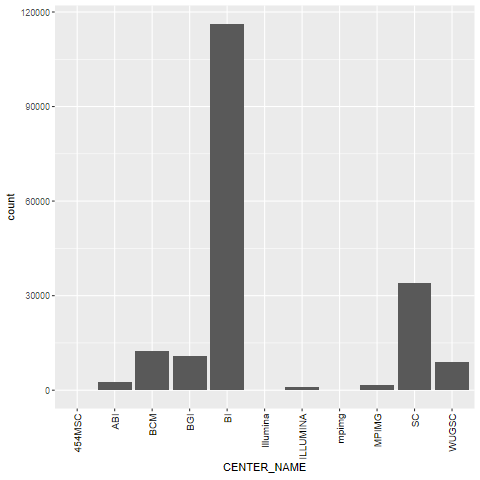

In [14]:
Image(filename='out.png')

In [15]:
robjects.r('yri_ceu <- seq.data[seq.data$POPULATION %in% c("YRI", "CEU") & seq.data$BASE_COUNT < 2E09 & seq.data$READ_COUNT < 3E07, ]')
yri_ceu = robjects.r('yri_ceu')

In [17]:
scatter = (ggplot2.ggplot(yri_ceu) +
           ggplot2.aes_string(x='BASE_COUNT', y='READ_COUNT',
                              shape='factor(POPULATION)', col='factor(ANALYSIS_GROUP)') +
           ggplot2.geom_point())

robjects.r.png('out1.png', type='cairo-png')
scatter.plot()
robjects.r('dev.off')()

1


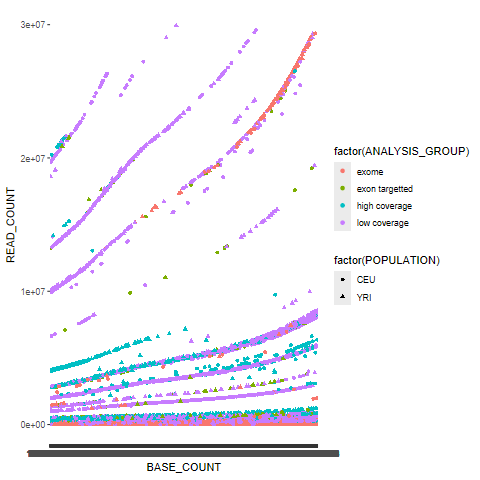

In [18]:
Image(filename='out1.png')

In [19]:
robjects.r("""
seq.data$BASE_COUNT <- as.numeric(seq.data$BASE_COUNT)
seq.data$READ_COUNT <- as.numeric(seq.data$READ_COUNT)
""")


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  :
R[write to console]: 
 
R[write to console]:  NAs introduced by coercion



In [20]:
robjects.r("""
yri_ceu <- seq.data[
    seq.data$POPULATION %in% c("YRI", "CEU") &
    seq.data$BASE_COUNT < 2e9 &
    seq.data$READ_COUNT < 3e7,
]
""")

yri_ceu = robjects.r("yri_ceu")


In [25]:
scatter = (
    ggplot2.ggplot(yri_ceu) +
    ggplot2.aes_string(
        x="BASE_COUNT",
        y="READ_COUNT",
        shape="factor(POPULATION)",
        col="factor(ANALYSIS_GROUP)"
    ) +
    ggplot2.geom_point() +
    ggplot2.scale_x_continuous(
        breaks=robjects.FloatVector([0, 5e8, 1e9, 1.5e9, 2e9])
    ) +
    ggplot2.scale_y_continuous(
        breaks=robjects.FloatVector([0, 1e7, 2e7, 3e7])
    )
)


In [26]:
robjects.r("str(yri_ceu$BASE_COUNT)")
robjects.r("str(yri_ceu$READ_COUNT)")


 num [1:29738] 3.34e+08 3.45e+08 5.37e+06 7.41e+07 7.41e+07 ...
 num [1:29738] 9280498 9571982 149044 2057690 2057690 ...


In [27]:
from rpy2.robjects import r

r.png("out2.png", width=1200, height=900, res=150, type="cairo-png")
r("print")(scatter)
r("dev.off")()


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 126 rows containing missing values or values outside the scale range (`geom_point()`). 



1


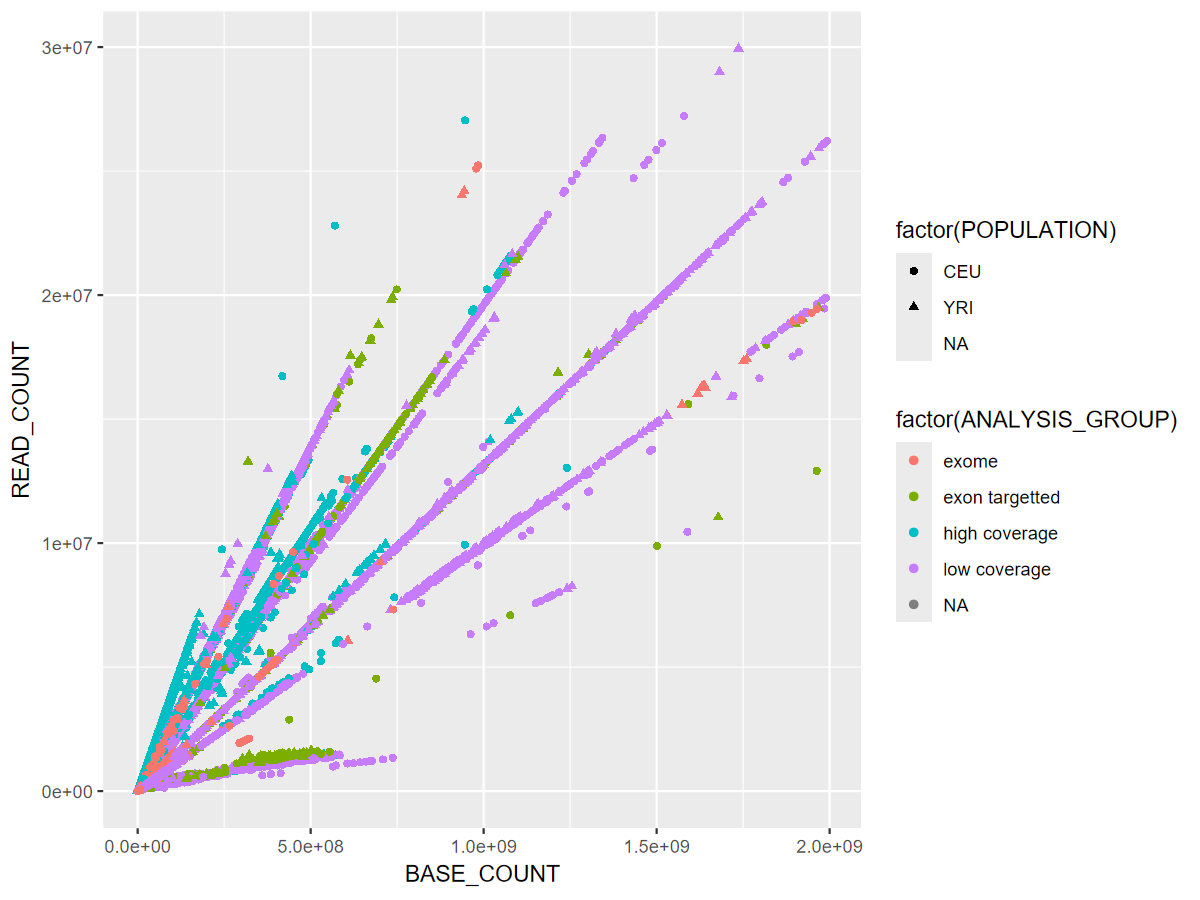

In [28]:
Image(filename='out2.png')